# WISDM Module Exam

### Instructions
Modify this notebook to compose your model. You may use additional `.py` files within this folder, `src/` for composing your framework.

### <span style="color:Orange;">  Table of Contents: </span>

I. Executive Summary

II. Problem Statement

III. Motivations

IV. Deep Learning Model
  
V. Result and discussion

VI. Conclusion and Recommendations

***

## <span style="color:Orange;"> I. Executive Summary </span>
`text here`

## <span style="color:Orange;"> II. Problem Statement </span>
`text here`

## <span style="color:Orange;"> III. Motivations </span>
`text here`

Importing Modules

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from datetime import datetime
from datetime import timedelta

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 40)   # displays max columns of the DataFrame 
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

To run the confusion matrix below:  
If module mixtend is not yet installed, download the module by copy-pasting this code `pip install mlxtend` to the terminal.

## <span style="color:Orange;"> IV. Deep Learning </span>
The WISDM Dataset contains 18 different labels 

<b> Non-hand-oriented activities:  </b>  
{walking, jogging, stairs, standing, kicking}  
<b> Hand-oriented activities (General): </b>  
{dribbling, playing catch, typing, writing, clapping, brushing teeth, folding clothes}  
<b> Hand-oriented activities (eating):  </b>  
{eating pasta, eating soup, eating sandwich, eating chips, drinking}  



<span style="color:Cyan;"> In this activity, the group opt to use the accelerometer of each devices: phone and watch to predict an individual's activity. </span>


Reading and Loading the Data

In [4]:
# Main directory containing the dataset
main_directory = "C:/Users/User/Downloads/wisdm-dataset/raw"

# Subdirectories for phone and watch
phone_directory = os.path.join(main_directory, "phone", "accel")
watch_directory = os.path.join(main_directory, "watch", "accel")

In [6]:
# Function to load data from text files
def load_data(directory):
    data = []
    labels = []
    dates = []

    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                for line in file:
                    values = line.strip().split(',')
                    x, y, z = map(lambda v: float(v.replace(';', '')), values[-3:])
                    activity_label = values[1]        
                    date = values[2]   
                    data.append([x, y, z])
                    labels.append(activity_label)
                    dates.append(date)

    return np.array(data), np.array(labels), np.array(dates)

In [34]:
# Load data for phone and watch
phone_data, phone_labels, phone_time = load_data(phone_directory)
watch_data, watch_labels, watch_time = load_data(watch_directory)

In [35]:
# transforming into pd Series
y_accel_watch = pd.Series(watch_labels, name='labels')
y_accel_phone = pd.Series(phone_labels, name='labels')

In [36]:
X_accel_watch = pd.DataFrame(watch_data, columns=['x', 'y', 'z'])
X_accel_phone = pd.DataFrame(phone_data, columns=['x', 'y', 'z'])

# Adding more df
o_accel_watch_df = pd.concat([X_accel_watch, (pd.Series(watch_labels, name='labels'))], axis=1)
o_accel_phone_df = pd.concat([X_accel_phone, (pd.Series(phone_labels, name='labels'))], axis=1)

o_accel_watch_df = pd.concat([o_accel_watch_df, (pd.Series(watch_time, name='time'))], axis=1)
o_accel_phone_df = pd.concat([o_accel_phone_df, (pd.Series(phone_time, name='time'))], axis=1)

```
# transforming time into seconds
o_accel_phone_df['time'] = o_accel_phone_df['time'] / 10**6
o_accel_phone_df['time'] = datetime.datetime.fromtimestamp(o_accel_phone_df['time'])

```

In [37]:
# for a more balanced data
def filter_and_head(df, labels, n_samples):
    filtered_data = {}
    for label in labels:
        filtered_data[label] = df[df['labels'] == label].head(n_samples).copy()
    return filtered_data

In [38]:
# Define the labels
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'O', 'P', 'Q', 'R', 'S']

# Call the function to filter and select the first 203112 rows for each label
filtered_phone_data = filter_and_head(o_accel_phone_df, labels, 203112)
filtered_watch_data = filter_and_head(o_accel_watch_df, labels, 203112)

# Concatenate the DataFrames from the filtered data
balanced_phone_data = pd.concat(filtered_phone_data.values(), ignore_index=True)
balanced_watch_data = pd.concat(filtered_watch_data.values(), ignore_index=True)

In [23]:
o_accel_watch_df.head(3)

,x,y,z,labels,time
0,7.091625,-0.591667,8.195502,A,90426708196641
1,4.972757,-0.158317,6.696732,A,90426757696641
2,3.253720,-0.191835,6.107758,A,90426807196641


### Visualization

#### <span style="color: Orange;"> Accelerometer Phone plot </span>

In [46]:
# Dictionary mapping labels to corresponding names
label_names = {
    'A': 'Walking',
    'B': 'Jogging',
    'C': 'Stairs',
    'D': 'Sitting',
    'E': 'Standing',
    'F': 'Typing',
    'G': 'Brushing Teeth',
    'H': 'Eating Soup',
    'I': 'Eating Chips',
    'J': 'Eating Pasta',
    'K': 'Drinking from Cup',
    'L': 'Eating Sandwich',
    'M': 'Kicking (Soccer Ball)',
    'O': 'Playing Catch w/Tennis Ball',
    'P': 'Dribbling (Basketball)',
    'Q': 'Writing',
    'R': 'Clapping',
    'S': 'Folding Clothes'
}

# Set labels based on the corresponding names
o_accel_phone_df['activities'] = o_accel_phone_df['labels'].map(label_names)


In [47]:
activities = o_accel_phone_df['activities'].value_counts().index
Fs = 10

In [52]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15,7), sharex=True)
    plot_axis(ax0, data['time'], data['x'], 'x-axis')
    plot_axis(ax1, data['time'], data['x'], 'y-axis')
    plot_axis(ax2, data['time'], data['x'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_ylim([min(y), max(y)]) 
    ax.grid(True)

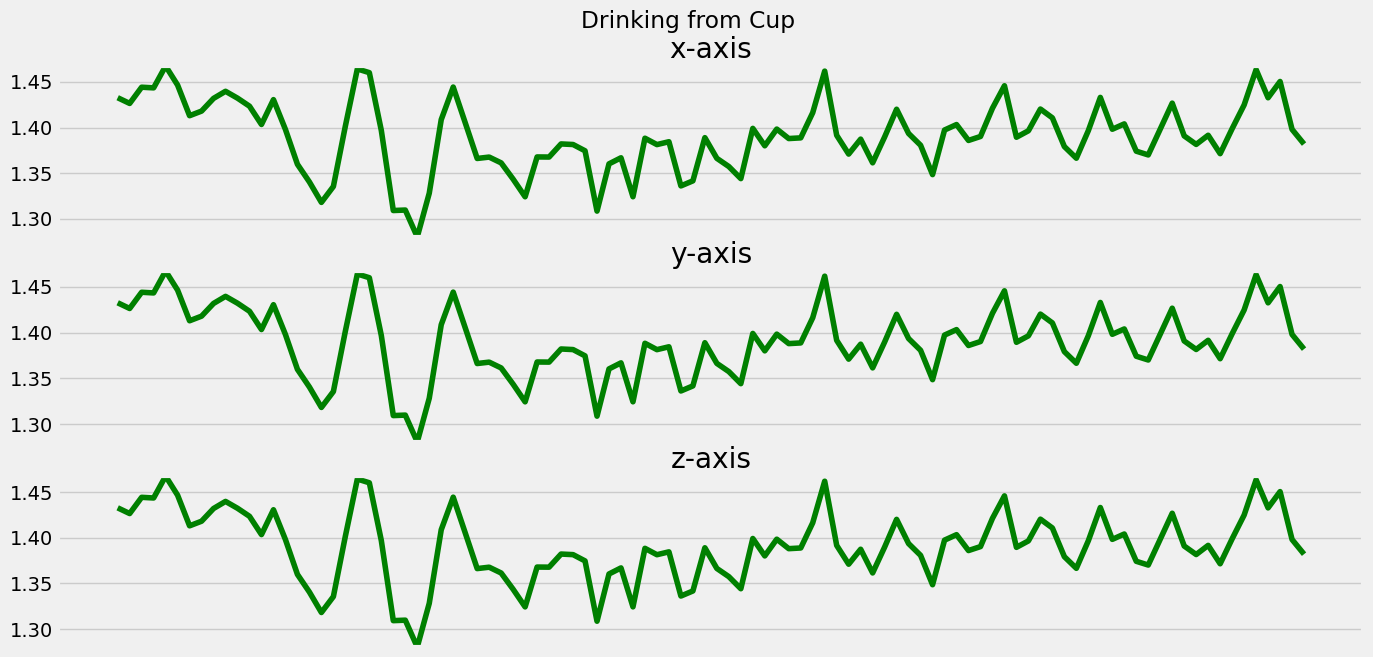

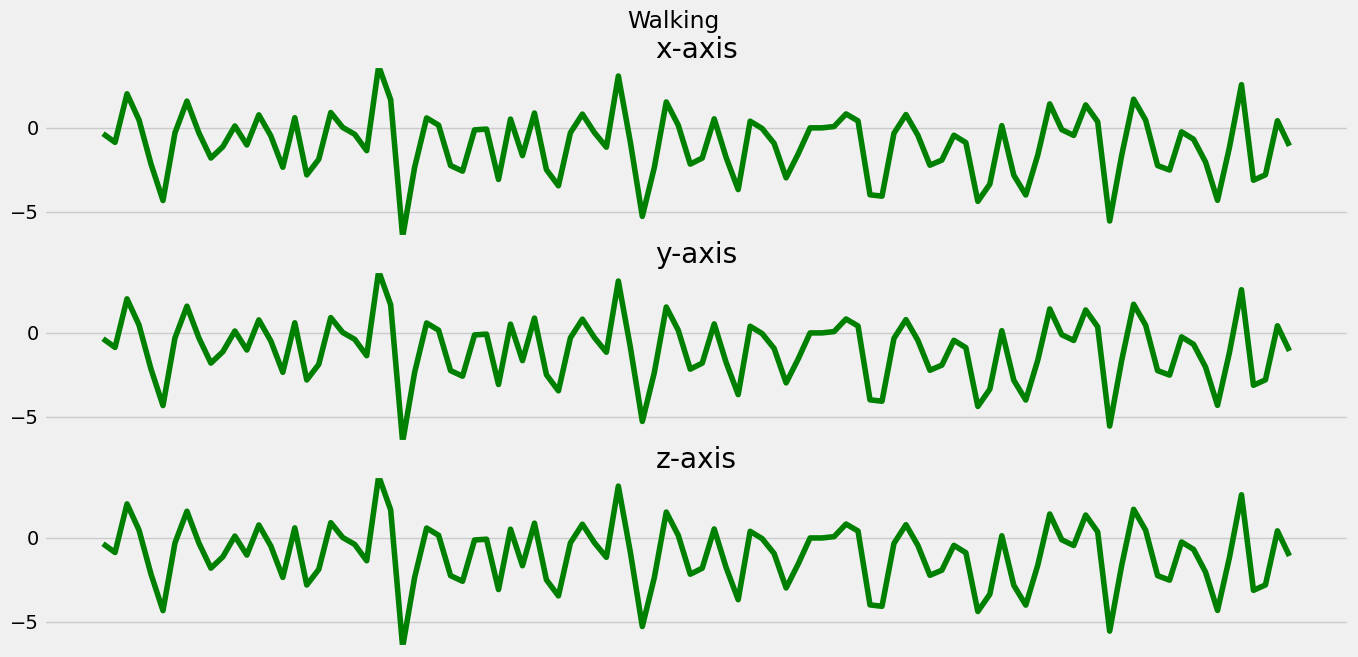

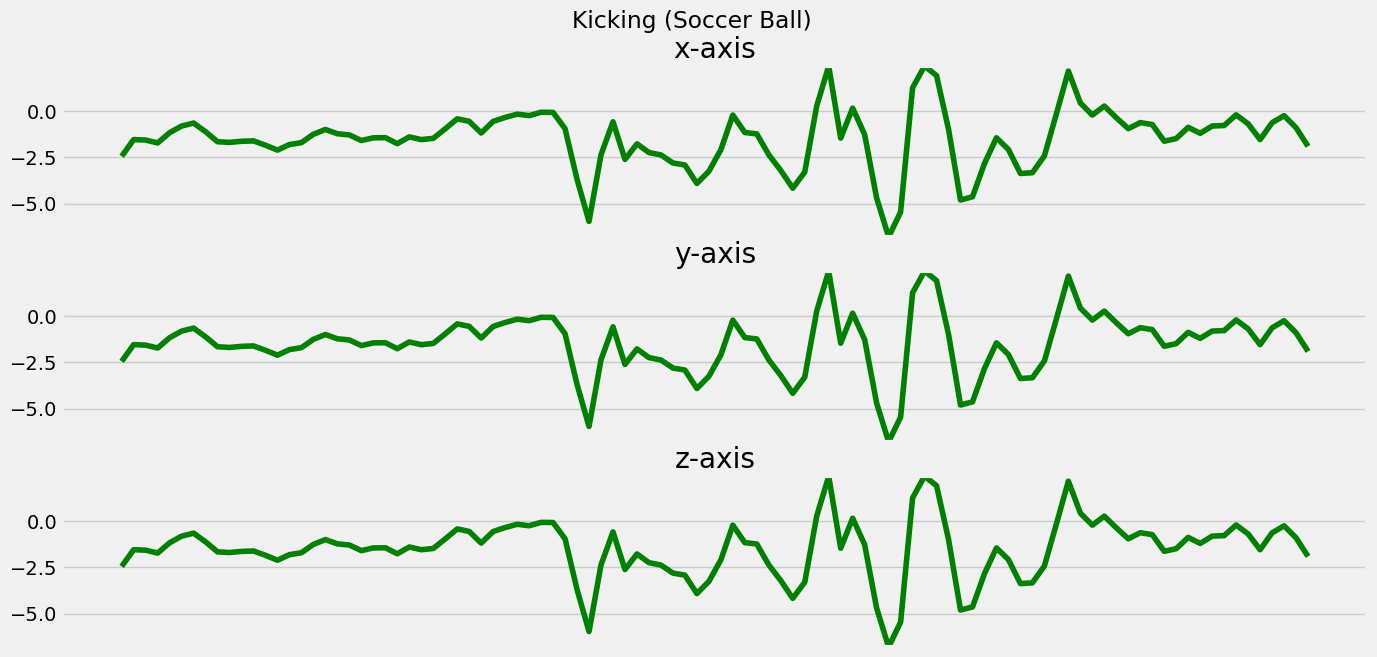

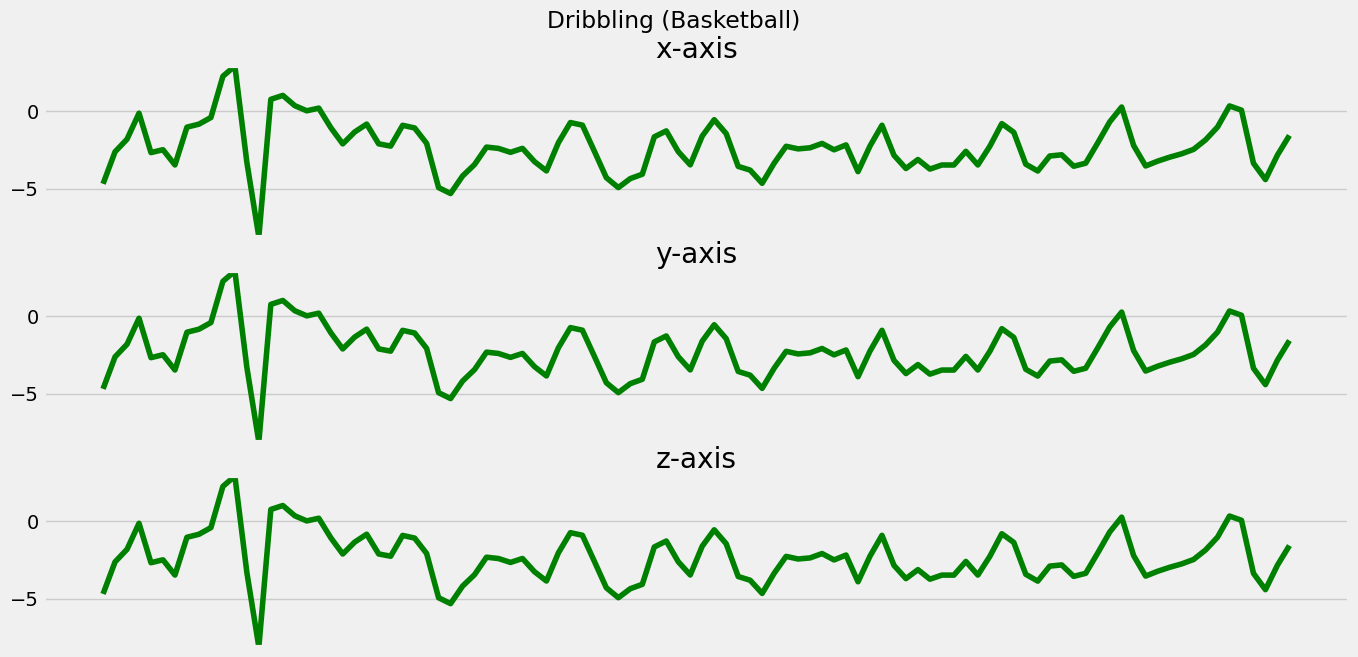

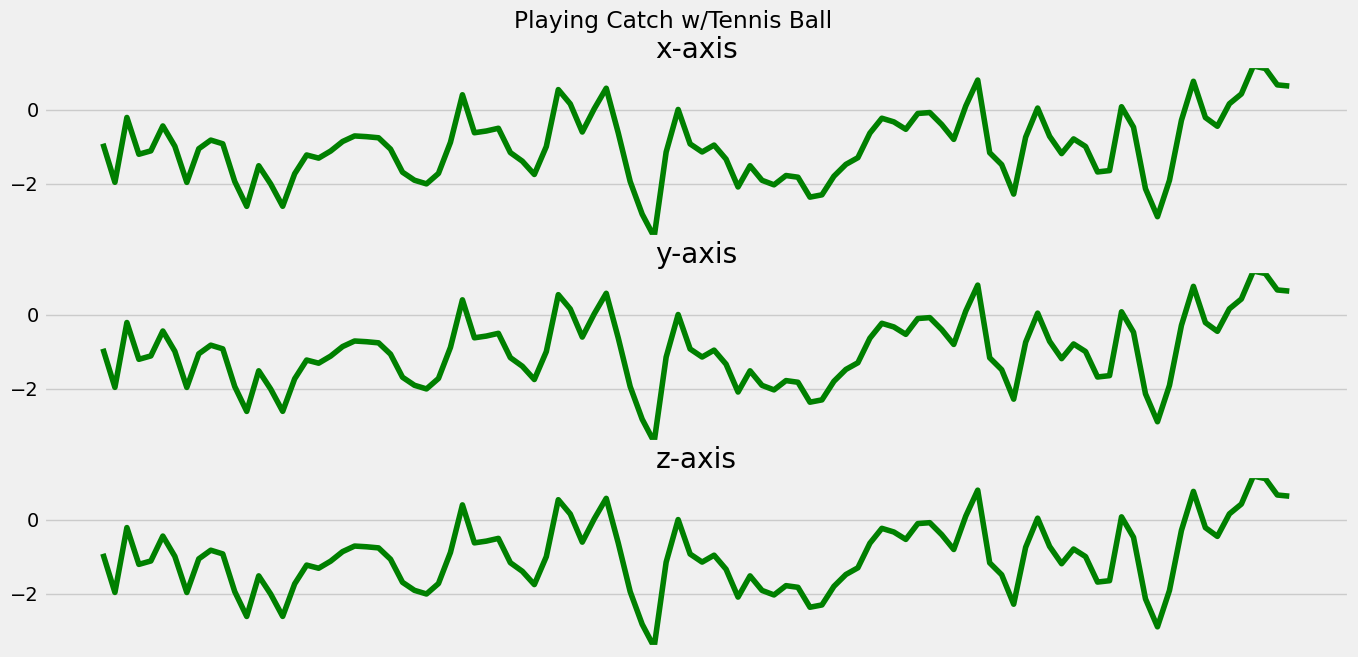

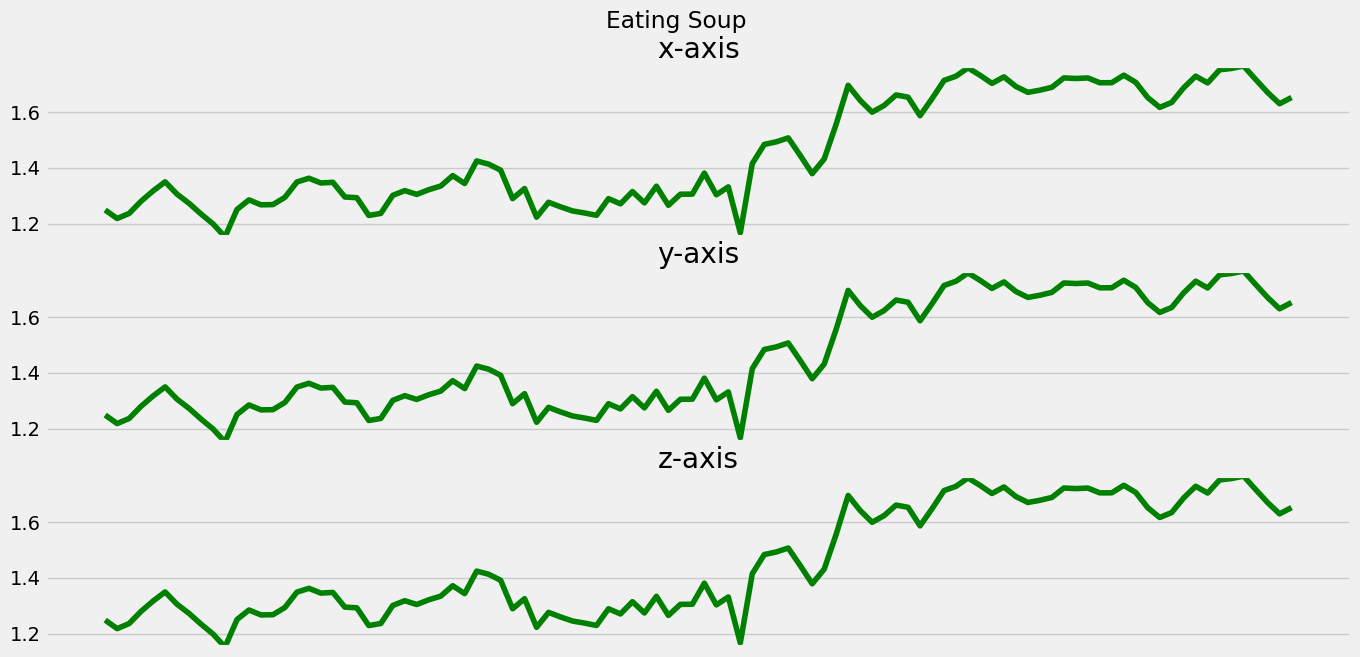

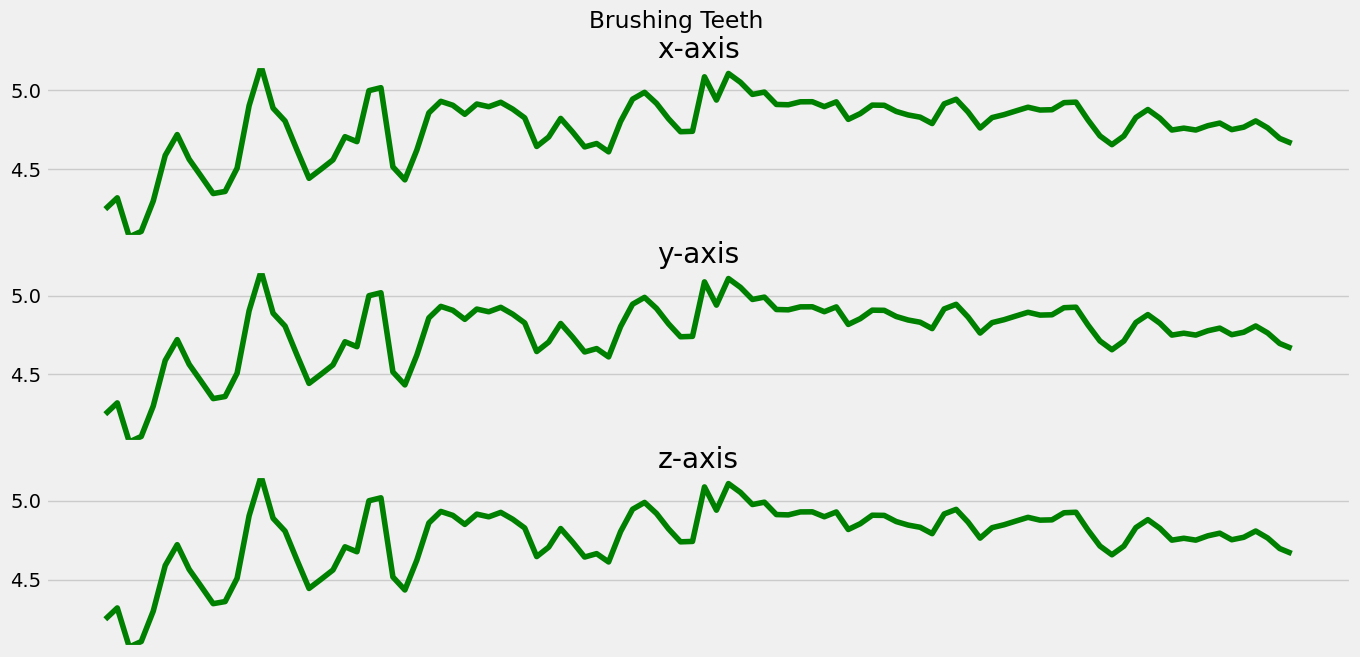

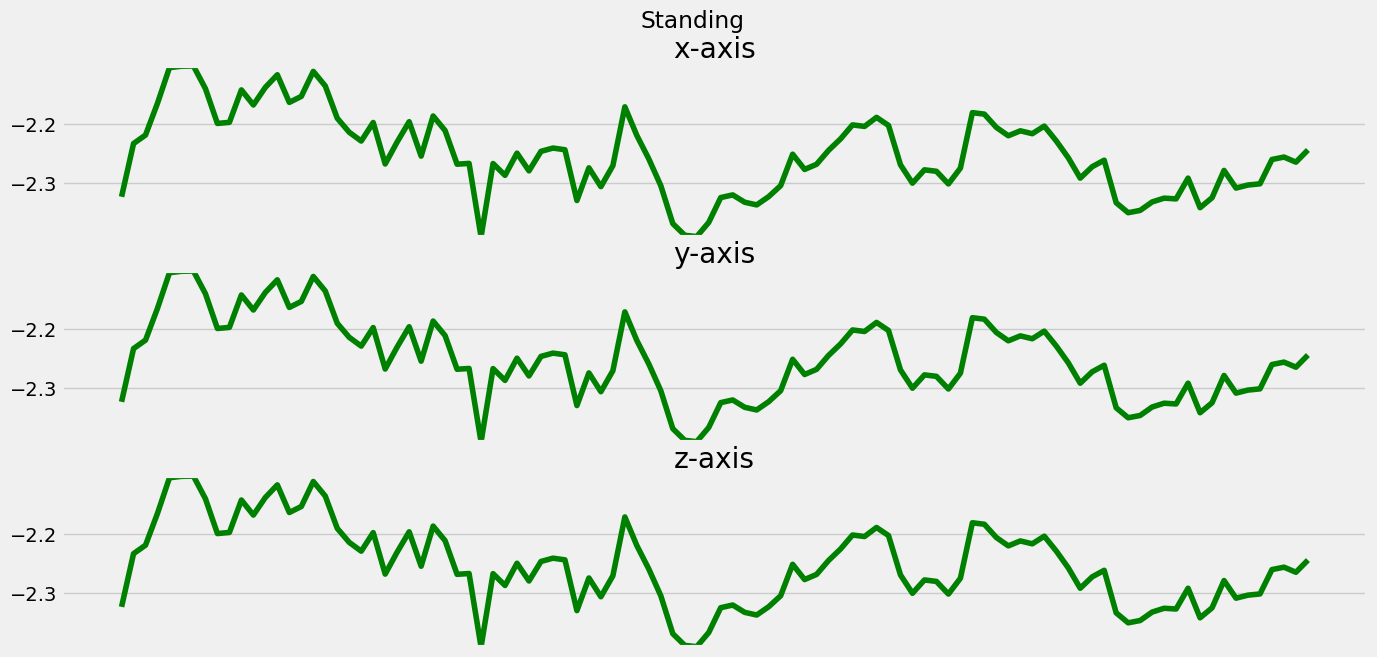

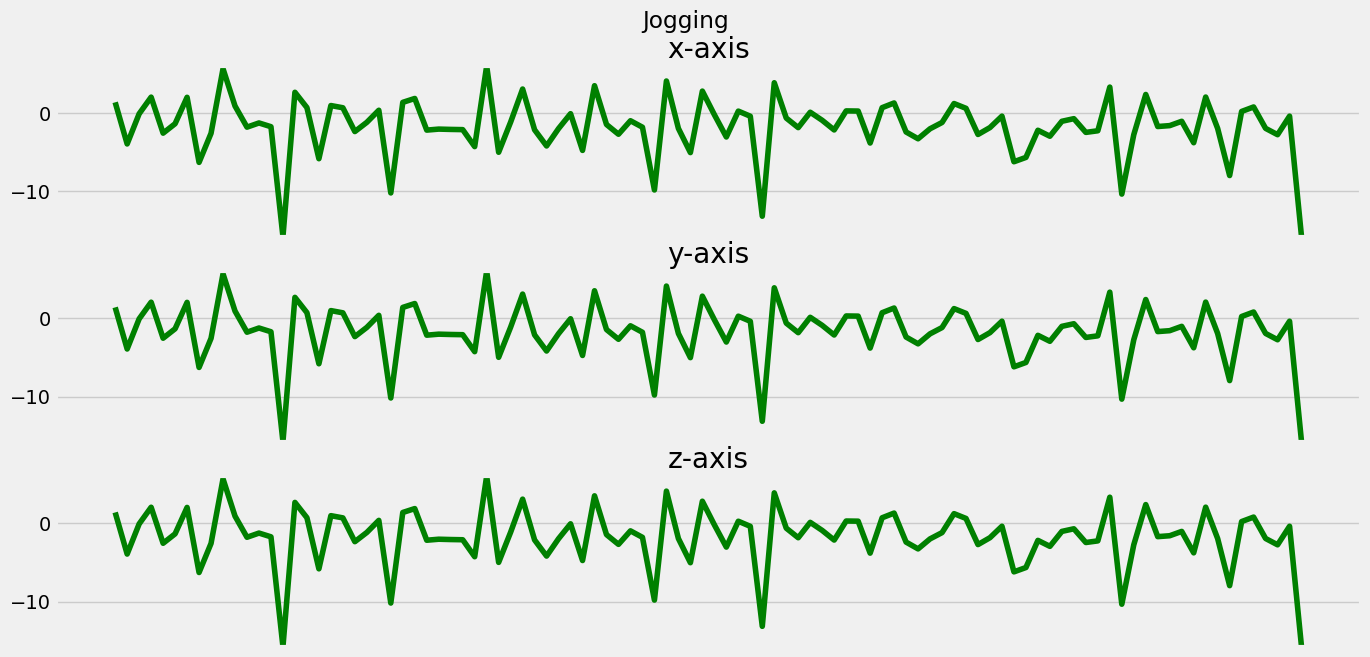

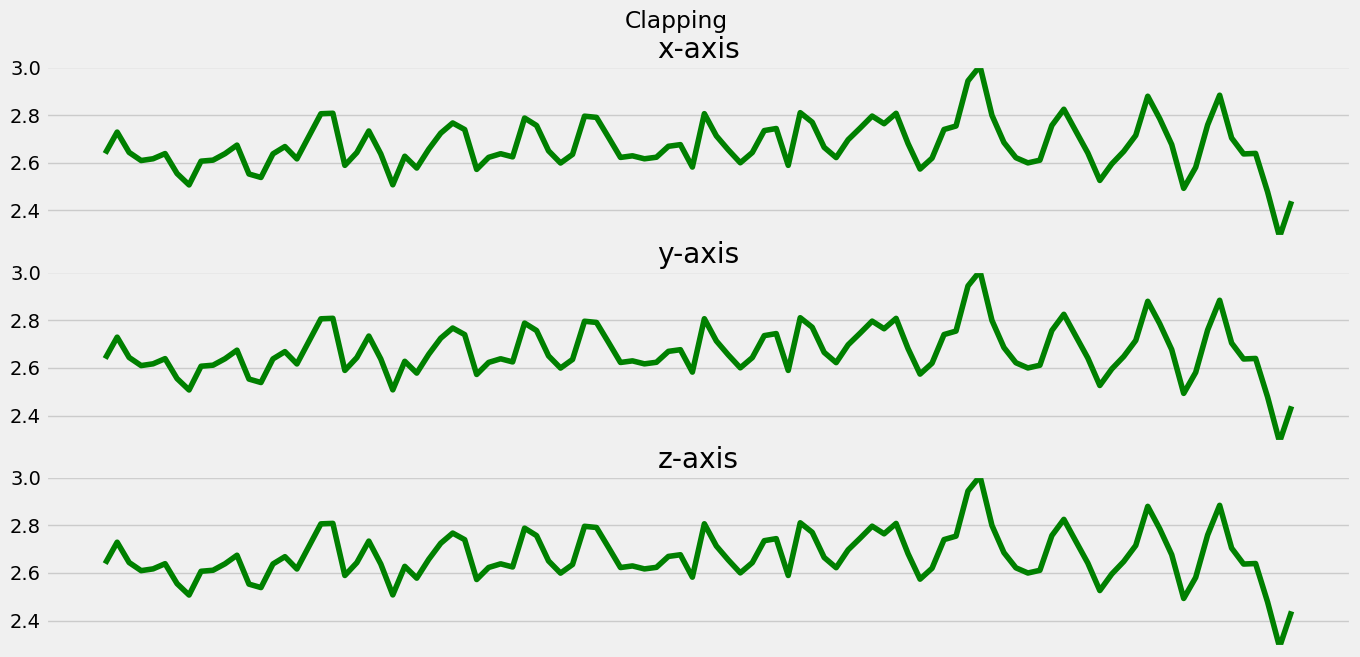

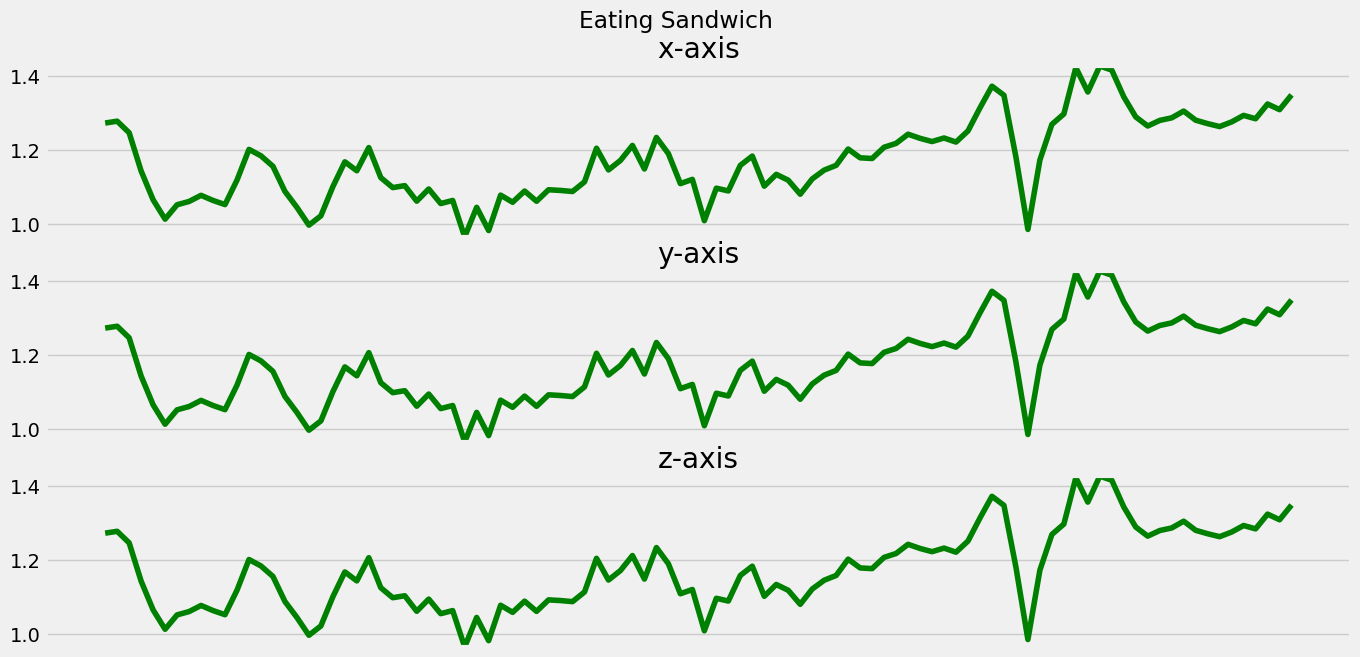

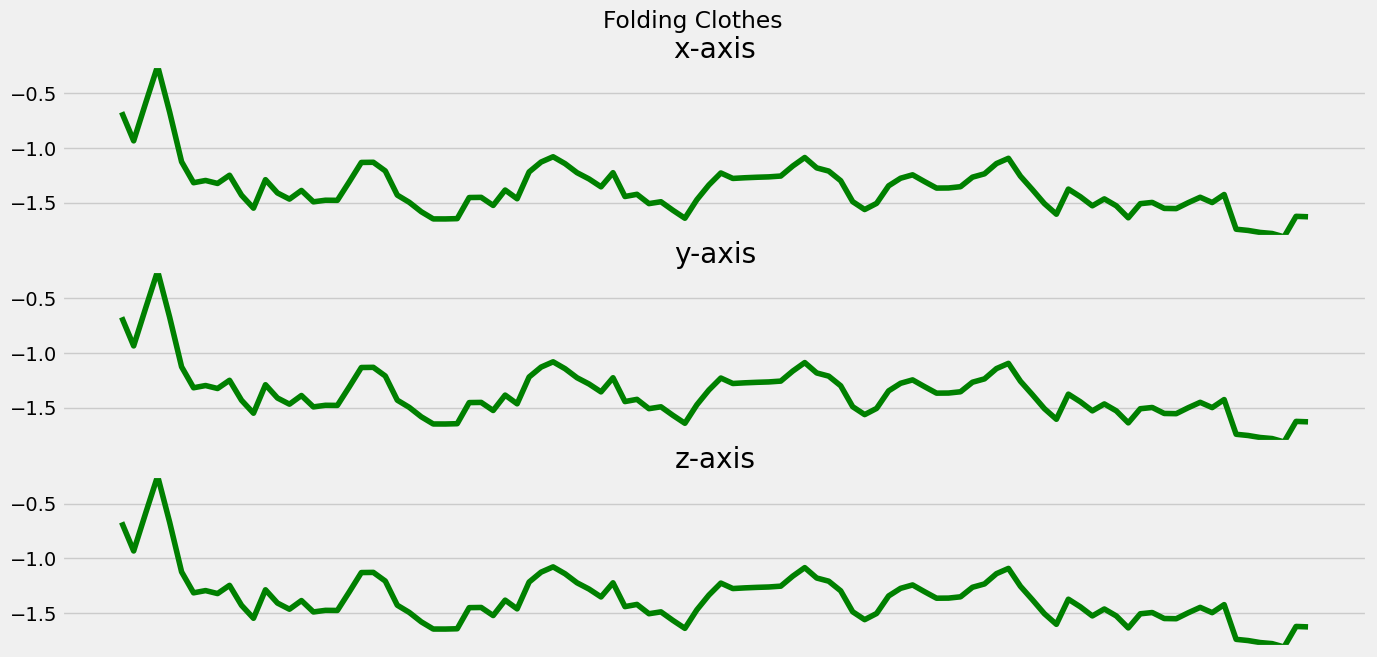

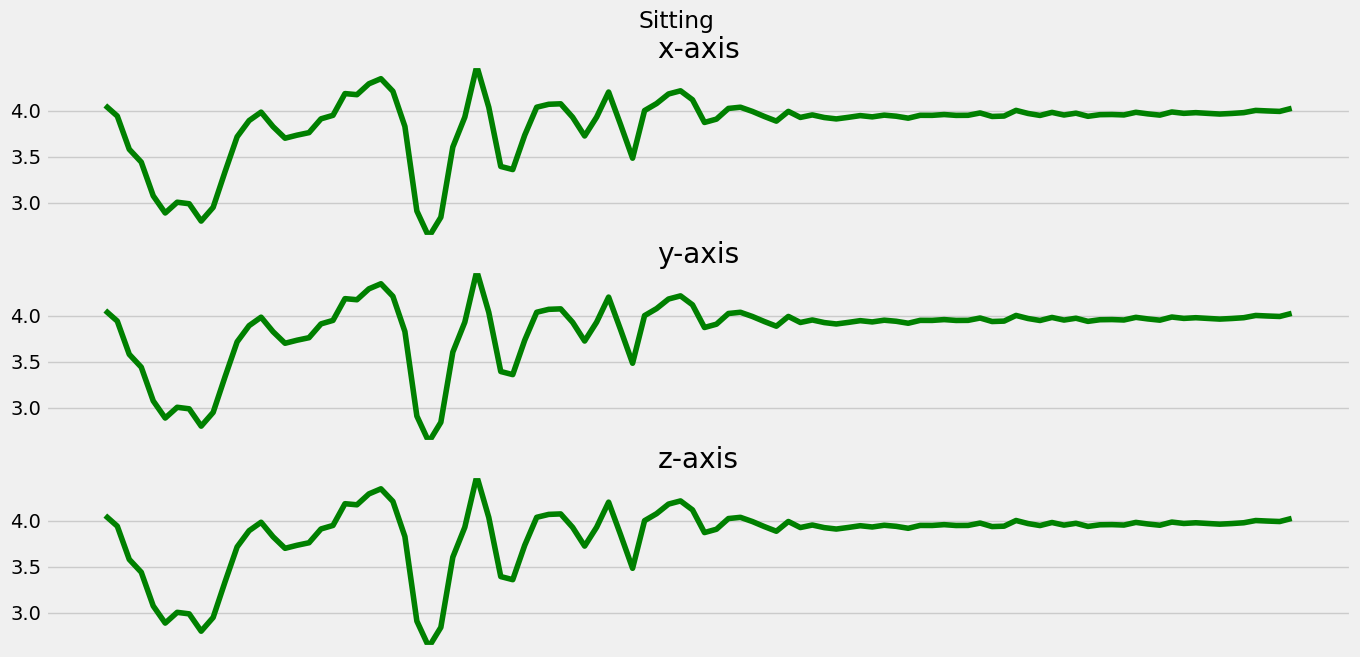

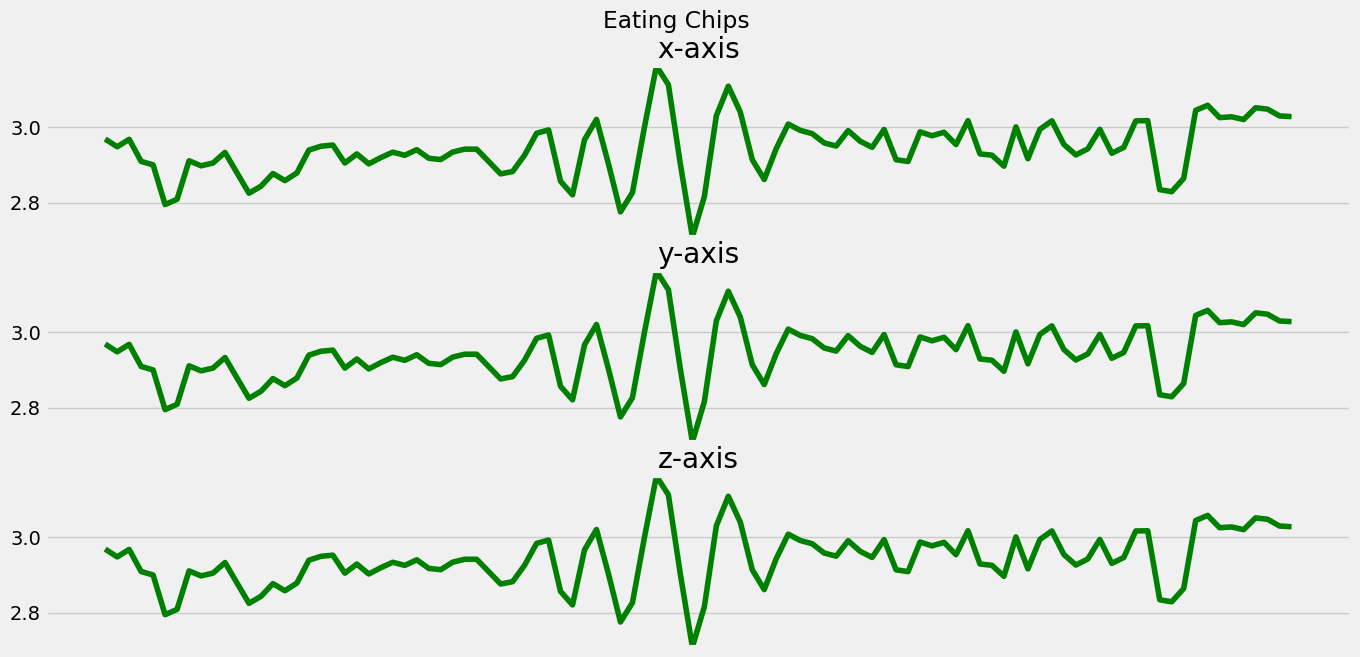

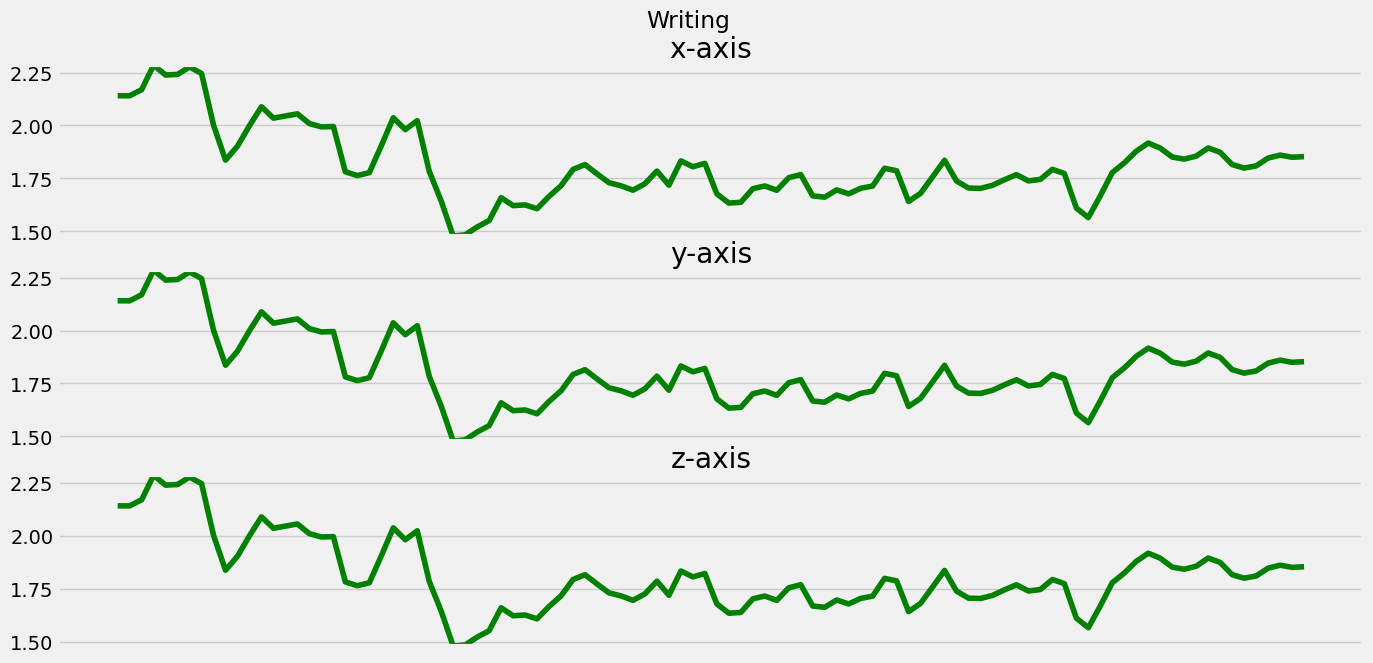

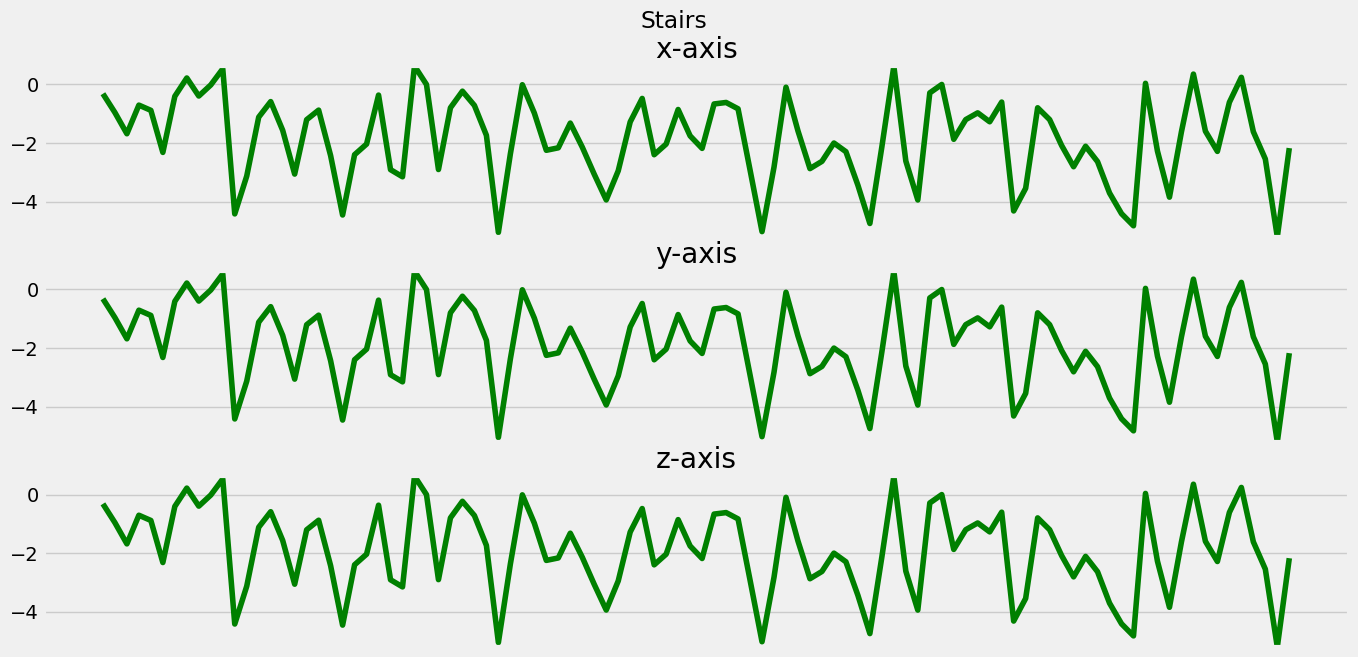

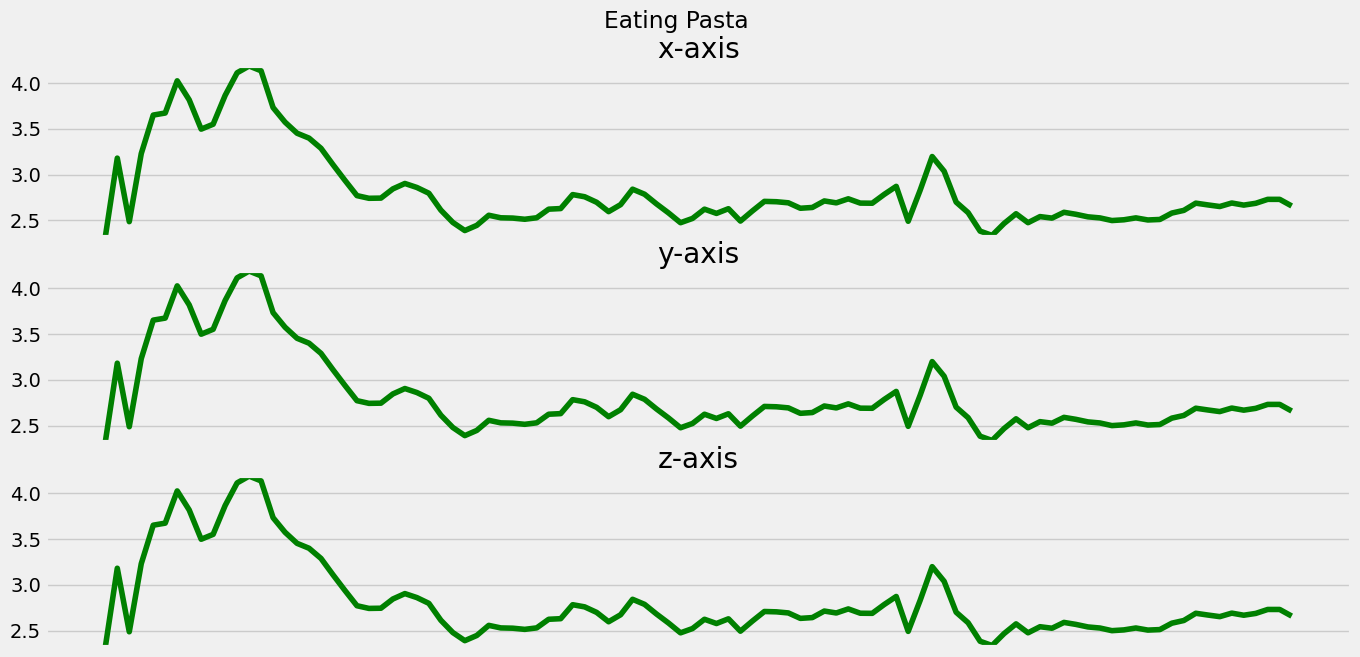

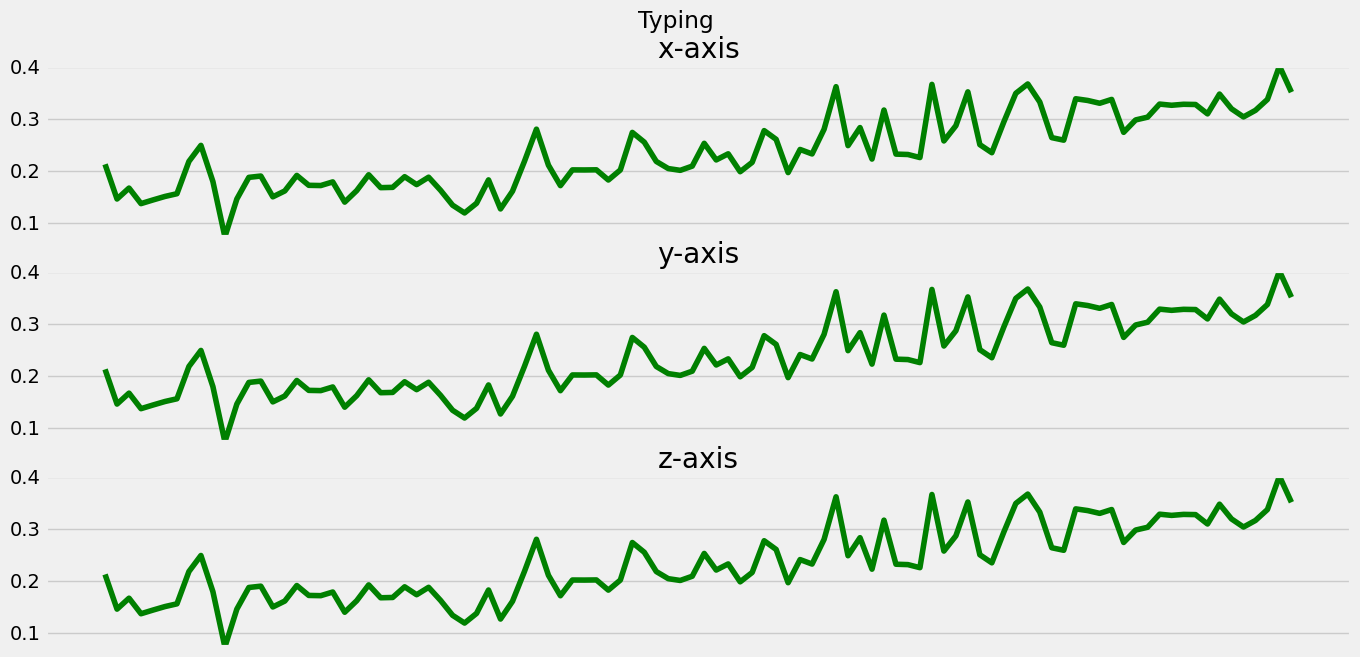

In [53]:
for activity in activities:
    data_for_plot = o_accel_phone_df[o_accel_phone_df['activities'] == activity][:Fs * 10]
    plot_activity(activity, data_for_plot)

Data Normalization and Encoding

In [ ]:
label = LabelEncoder()
balanced_phone_data['labels'] = label.fit_transform(balanced_phone_data['labels'])  # transforms the labels into numbers
balanced_watch_data['labels'] = label.fit_transform(balanced_watch_data['labels'])

In [ ]:
# Separating X from y
X_phone = balanced_phone_data[['x', 'y', 'z']]
y_phone = balanced_phone_data['labels']

X_watch = balanced_watch_data[['x', 'y', 'z']]
y_watch = balanced_watch_data['labels']

# Standardizing the data
scaler = StandardScaler()
X_phone = scaler.fit_transform(X_phone)
X_watch = scaler.fit_transform(X_watch)

# Creating another dataframe
scaled_X_phone = pd.DataFrame(data=X_phone, columns=['x', 'y', 'z'])
scaled_X_phone['labels'] = y_phone.values

scaled_X_watch = pd.DataFrame(data=X_watch, columns=['x', 'y', 'z'])
scaled_X_watch['labels'] = y_watch.values

Frame Preparation

In [73]:
# Frame Preparation
Fs = 20                              # Sensor polling rate
window_size = 50                     # Seconds required for predicting data
frame_size = Fs * window_size    #1,000     # For dimension purposes
steps = Fs * 17

In [74]:
def get_frames(df, frame_size, steps):
    N_FEATURES = 3              # number of columns (x, y, z)
    frames = []
    labels = []

    for i in range(0, len(df) - frame_size, steps):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]

        # Retrieve the most often used label in this segment
        label = stats.mode(df['labels'][i: i + frame_size])[0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segment into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels       

Creating a model first on predicting the activity using the Phone Accelerometer

In [75]:
X, y = get_frames(scaled_X_phone, frame_size, steps)

In [76]:
X.shape, y.shape 

((10751, 1000, 3), (10751,))

In [78]:
(203112*18)/340

10752.988235294117

Spltting the data into train and test

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [80]:
X_train.shape, X_test.shape 

((8600, 1000, 3), (2151, 1000, 3))

In [81]:
X_train[0].shape, X_test[0].shape 

((1000, 3), (1000, 3))

In [83]:
# reshaping the data to have an additional dimension
X_train = X_train.reshape(8600, 1000, 3, 1)
X_test = X_test.reshape(2151, 1000, 3, 1)

In [84]:
X_train[0].shape, X_test[0].shape 

((1000, 3, 1), (1000, 3, 1))

## Training the Model

2D CNN Model

In [86]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, (2, 2), activation='relu', input_shape = X_train[0].shape),
                                    tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
                                    tf.keras.layers.Dropout(0.2),

                                    tf.keras.layers.Flatten(),

                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),

                                    tf.keras.layers.Dense(18, activation='softmax')
                                    ])

In [89]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [90]:
history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.0837 - loss: 2.8504 - val_accuracy: 0.1980 - val_loss: 2.3773
Epoch 2/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.1383 - loss: 2.5200 - val_accuracy: 0.2143 - val_loss: 2.1966
Epoch 3/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.1639 - loss: 2.3607 - val_accuracy: 0.2589 - val_loss: 2.0929
Epoch 4/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.1844 - loss: 2.2768 - val_accuracy: 0.2706 - val_loss: 2.0571
Epoch 5/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.1910 - loss: 2.2473 - val_accuracy: 0.2701 - val_loss: 2.0533
Epoch 6/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.1988 - loss: 2.2252 - val_accuracy: 0.2831 - val_loss: 2.0526
Epoch 7/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.1985 - loss: 2.2174 - val_accuracy: 0.2552 - val_loss: 2.0364
Epoch 8/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.1988 - loss: 2.1919 - 

In [93]:
def plot_learningCurve(history, epochs):
    # Plot training and validaiton accuracy values
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training and validaiton loss values
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

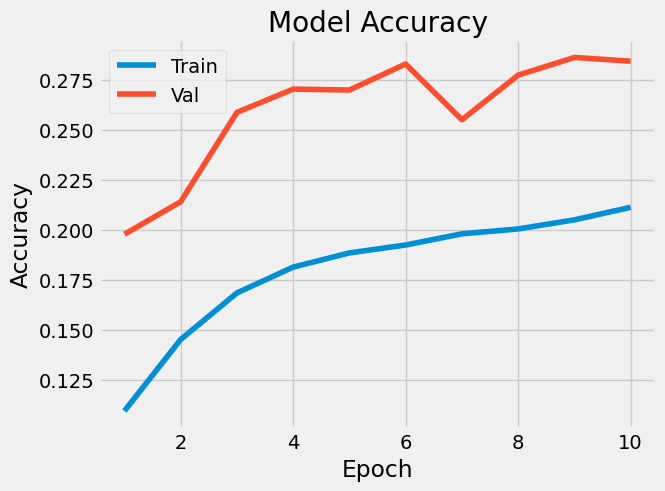

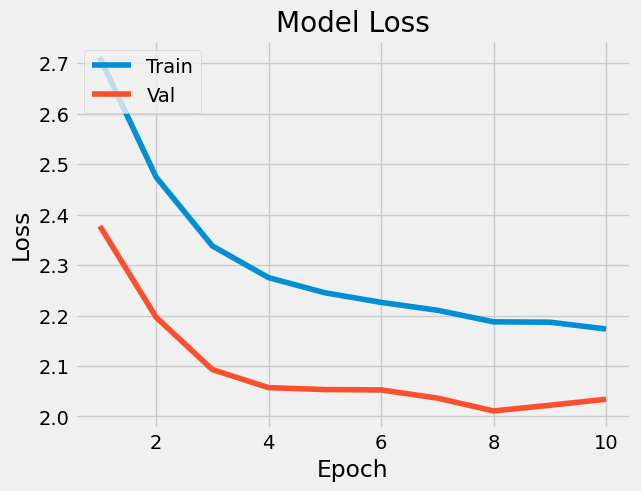

In [94]:
plot_learningCurve(history, 10)

### Tuning the Learning Rate

In [131]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (2,2), activation="relu",
                      input_shape = X_train[0].shape),
  tf.keras.layers.Reshape((X_train[0].shape[1], -1)),  # Collapse height and width into timesteps
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, (2, 2), activation='relu', input_shape = X_train[0].shape),
                                    tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
                                    tf.keras.layers.Dropout(0.2),

                                    tf.keras.layers.Flatten(),

                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),

                                    tf.keras.layers.Dense(18, activation='softmax')
                                    ])

In [132]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(3,)),  # Assuming x, y, z values
    Dense(32, activation='relu'),
    Dense(len(activities), activation='softmax')  # Output layer with number of activities
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

In [133]:
# Get initial weights
init_weights = model.get_weights()

In [134]:
## RUN TO RESET
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [135]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(X_train, y_train, epochs=25, callbacks=[lr_schedule])

Epoch 1/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - loss: 6.4185 - learning_rate: 1.0000e-08
Epoch 2/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 40s 147ms/step - loss: 4.5083 - learning_rate: 1.1220e-08
Epoch 3/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 37s 136ms/step - loss: 4.2141 - learning_rate: 1.2589e-08
Epoch 4/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 40s 149ms/step - loss: 4.1480 - learning_rate: 1.4125e-08
Epoch 5/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 38s 143ms/step - loss: 4.1046 - learning_rate: 1.5849e-08
Epoch 6/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step - loss: 4.0740 - learning_rate: 1.7783e-08
Epoch 7/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 37s 138ms/step - loss: 3.9971 - learning_rate: 1.9953e-08
Epoch 8/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 37s 138ms/step - loss: 4.0018 - learning_rate: 2.2387e-08
Epoch 9/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 39s 144ms/step - loss: 4.0031 - learning_rate: 2.5119e-08
Epoch 10/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 39s 143ms/step - loss: 3.9667 - learning_rate: 2.8184e-08
Epoch 11/25
269/269

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

### Confusion Matrix
If the color is mostly concentrated around the diagonal line (i.e. <span style="color:Blue;"> A </span> of true label and <span style="color:Blue;"> A </span> of predicted label has the strongest color), the model has a better accuracy rate

In [109]:
y_pred = model.predict(X_test)

# Transforms the y_pred into a discrete label
y_pred = np.argmax(y_pred, axis=1)

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

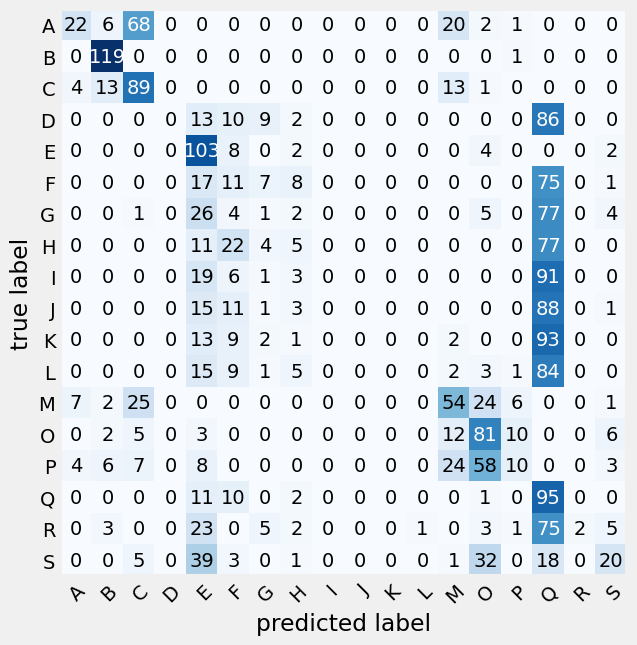

In [110]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=False, figsize=(7,7))

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [102]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

array([ 3, 15,  4, ..., 15, 10,  3])

## <span style="color:Orange;"> V. Results and Discussion </span>
`text here`

## <span style="color:Orange;"> VI. Conclusion and Recommendation </span>
`text here`